In [1]:
#|export
from __future__ import annotations
import random,math,torch,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *

In [2]:
import torch.nn.functional as F,matplotlib as mpl
from pathlib import Path
from operator import attrgetter,itemgetter
from contextlib import contextmanager

from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

In [3]:
#|export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [4]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

  0%|          | 0/2 [00:00<?, ?it/s]

In [15]:


def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

In [16]:
from torcheval.metrics import MulticlassAccuracy

In [17]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [18]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.158,2.296,0,train
0.299,1.986,0,eval


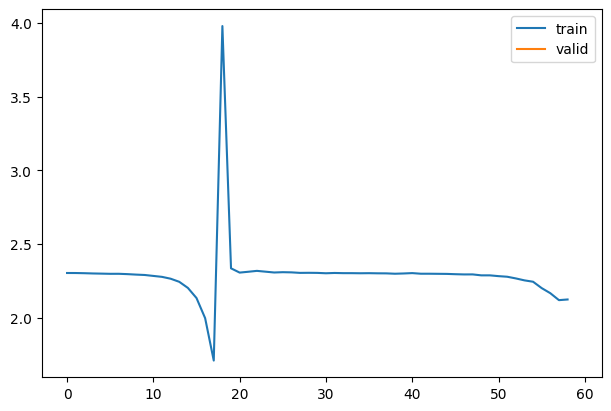

In [9]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

In [11]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds [i].append(to_cpu(x).std ())
        return x
    
    def __iter__(self): return iter(self.layers)

accuracy,loss,epoch,train
0.158,2.296,0,train
0.299,1.986,0,eval


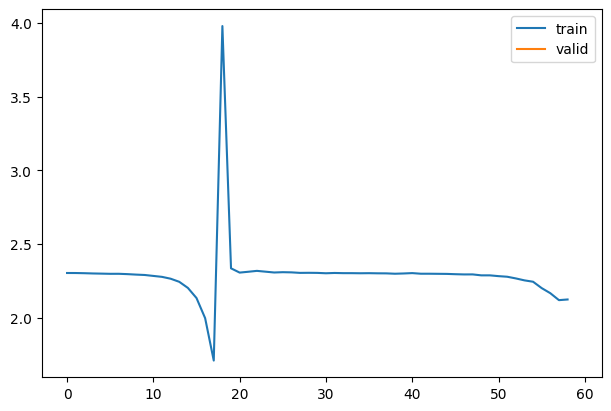

In [12]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

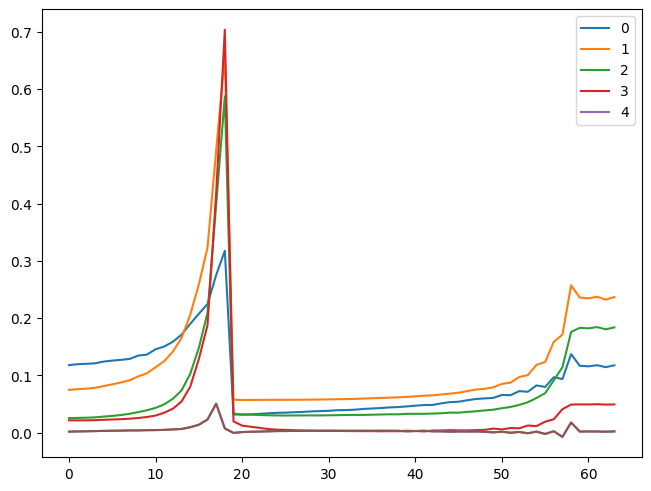

In [13]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

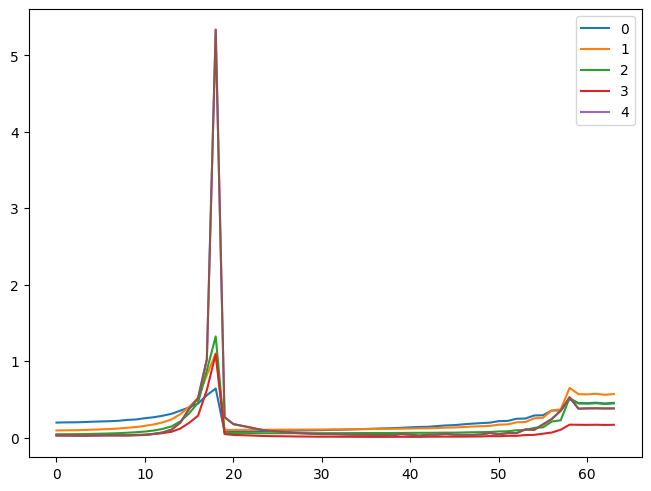

In [14]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));